In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm

from multiprocessing import Pool, cpu_count

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras.callbacks import LambdaCallback, EarlyStopping
import matplotlib.pyplot as plt
from skimage import io, transform
from spectral import get_rgb

In [2]:
df_train = pd.read_csv('inputs/train_v2.csv')
df_train.head(2)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water


In [3]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
print(labels)

['slash_burn', 'clear', 'blooming', 'primary', 'cloudy', 'conventional_mine', 'water', 'haze', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'blow_down', 'agriculture', 'road', 'selective_logging']


In [49]:
input_dir = 'inputs'
img_size = 256
tag_of_interest = 'habitation'

X = []
Y = []
for f, tags in tqdm(df_train.values, miniters=1000):
    f_name = '{}.tif'.format(f)
    img = io.imread(os.path.join(input_dir, 'train-tif-v2', f_name))
    targets = 0
#     for t in tags.split(' '):
#         targets[label_map[t]] = 1
    if tag_of_interest in tags:
        targets = 1
    # Take only near infrared channel
    X.append(img[:,:,3])
#     X.append(img)
#     X.append(transform.resize(img, (img_size, img_size)))
    Y.append(targets)

X = np.array(X, np.float16) / 255.
Y = np.array(Y, np.uint8)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], 1))
Y = np.reshape(Y, (Y.shape[0], 1))

print(X.shape)
print(Y.shape)

100%|██████████| 40479/40479 [00:21<00:00, 1841.31it/s]


(40479, 256, 256, 1)
(40479, 1)


In [50]:
# X_train, X_valid, Y_train, Y_valid = train_test_split(np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], 1)), Y,
#                                                       test_size=0.2, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=0)

In [75]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(img_size,img_size,1)))
model.add(Conv2D(32, (16, 16), strides=4, padding='same', activation='relu', input_shape=(img_size,img_size,1)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (9, 9), strides=4, padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, (2, 2), padding='same', activation='relu'))
# model.add(Conv2D(512, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])

In [82]:
# model.summary()
len(Y_valid[Y_valid==1])

732

In [77]:
np.random.seed(0)
scores = []
batch_size = 128
epochs = 45

def my_callback_func(batch,logs):
    p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
    score = fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2)
    scores.append(score)


my_callback = LambdaCallback(on_epoch_end=lambda batch,logs: my_callback_func(batch,logs))
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0)
callbacks = [my_callback, early_stop]
# callbacks = [my_callback]

history_callback = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2,
          validation_data=(X_valid, Y_valid), callbacks=callbacks)

print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))

Train on 32383 samples, validate on 8096 samples
Epoch 1/45
31s - loss: 1.4540 - acc: 0.9090 - val_loss: 1.4573 - val_acc: 0.9096
Epoch 2/45
30s - loss: 1.4574 - acc: 0.9096 - val_loss: 1.4573 - val_acc: 0.9096
Epoch 3/45
31s - loss: 1.4574 - acc: 0.9096 - val_loss: 1.4573 - val_acc: 0.9096
Epoch 4/45
30s - loss: 1.4574 - acc: 0.9096 - val_loss: 1.4573 - val_acc: 0.9096
Epoch 5/45


KeyboardInterrupt: 

Max score 0.332003 at epoch 5


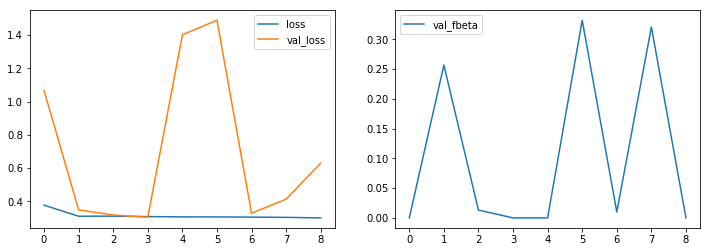

In [64]:
print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.legend(labels=['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(scores)
plt.legend(labels=['val_fbeta'])
plt.show()

In [44]:
p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
p_valid = (p_valid > 0.2).astype(int)

In [45]:
for i in range(17):
    print("%s: %f" % (inv_label_map[i], fbeta_score(Y_valid[:,i], p_valid[:,i], beta=2)))
print("Average score %f" % fbeta_score(Y_valid, p_valid, beta=2, average='samples'))

slash_burn: 0.000000
clear: 0.922152
blooming: 0.000000
primary: 0.984634
cloudy: 0.000000
conventional_mine: 0.000000
water: 0.000000
haze: 0.000000
cultivation: 0.000000
partly_cloudy: 0.528586
artisinal_mine: 0.000000
habitation: 0.000000
bare_ground: 0.000000
blow_down: 0.000000
agriculture: 0.681971
road: 0.000000
selective_logging: 0.000000
Average score 0.688313


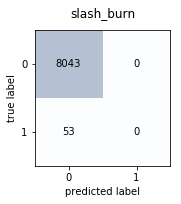

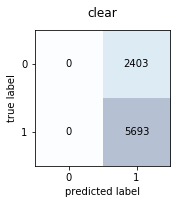

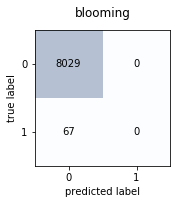

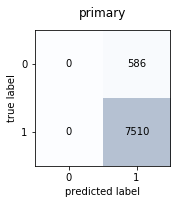

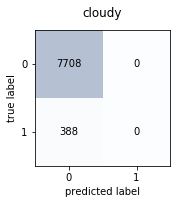

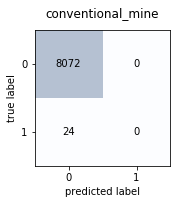

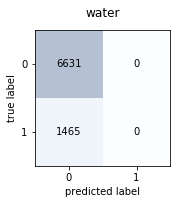

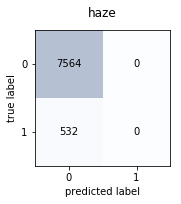

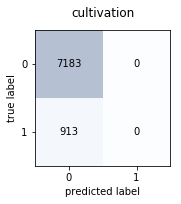

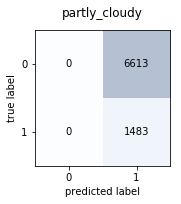

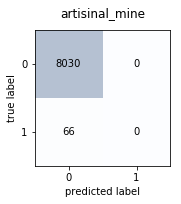

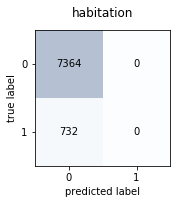

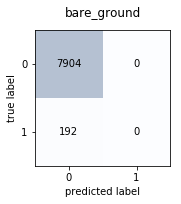

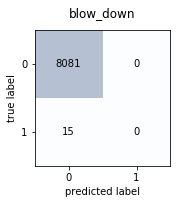

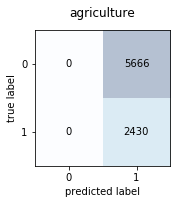

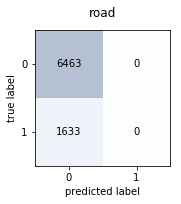

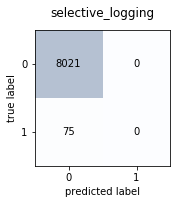

In [46]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
for i in range(17):
    cm = confusion_matrix(y_target=Y_valid[:,i], 
                      y_predicted=p_valid[:,i], binary=False)
    _, ax = plot_confusion_matrix(conf_mat=cm)
    ax.set_title(inv_label_map[i])
plt.show()